In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#zip_path = "/content/Satellite Image Classification.zip"
extract_path = "/content/drive/MyDrive/Satellite Image Classification"

In [ ]:
data_path = extract_path
train_dir = os.path.join(data_path, "data")
val_dir = os.path.join(data_path, "data")


In [ ]:
print(os.listdir(val_dir))

['water', 'green_area', 'desert', 'cloudy']


In [ ]:
print("Folders in train directory:", os.listdir(train_dir))

Folders in train directory: ['water', 'green_area', 'desert', 'cloudy']


In [ ]:
sample_class = os.listdir(train_dir)[0]
sample_image = os.listdir(os.path.join(train_dir, sample_class))[0]
image_path = os.path.join(train_dir, sample_class, sample_image)
sample_img = plt.imread(image_path)


# RGB to Gray Scale

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Define paths
input_folders = ["/content/drive/MyDrive/Satellite Image Classification/data/cloudy",
    "/content/drive/MyDrive/Satellite Image Classification/data/desert",
    "/content/drive/MyDrive/Satellite Image Classification/data/green_area",
    "/content/drive/MyDrive/Satellite Image Classification/data/water"
]
output_folders = ["/content/Satellite Image Classification/preprocessed_cloudy",
                 "/content/Satellite Image Classification/preprocessed_desert",
                 "/content/Satellite Image Classification/preprocessed_green_area",
                 "/content/Satellite Image Classification/preprocessed_water"
]

# Create output directories if they don't exist
for folder in output_folders:
    os.makedirs(folder, exist_ok=True)

# Convert images to grayscale
for input_folder, output_folder in zip(input_folders, output_folders):  # Iterate through corresponding input/output folders
    for img_name in tqdm(os.listdir(input_folder)):
        img_path = os.path.join(input_folder, img_name)
        gray_path = os.path.join(output_folder, img_name)

        img = cv2.imread(img_path)  # Read as RGB
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

        cv2.imwrite(gray_path, gray_img)  # Save grayscale image

print("Conversion to grayscale completed!")

100%|██████████| 1500/1500 [00:54<00:00, 27.60it/s] 

Conversion to grayscale completed!


In [ ]:
img_size = (64, 64)
validation_split = 0.3  # Increased from 0.25 to 0.3
batch_size = 32

# Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=validation_split
)

train_generator = data_gen.flow_from_directory(
    train_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical', color_mode='rgb',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    val_dir, target_size=img_size,
    batch_size=batch_size, class_mode='categorical', color_mode='rgb',
    subset='validation'
)

Found 3949 images belonging to 4 classes.
Found 1692 images belonging to 4 classes.


In [ ]:
from collections import Counter # Import Counter from collections

class_counts = Counter(train_generator.classes)
total_samples = sum(class_counts.values())
class_weight = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# CNN

In [ ]:
from tensorflow.keras.regularizers import l2  # Import l2 regularizer
from tensorflow.keras.layers import BatchNormalization # Import BatchNormalization
model = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),  # Increased dropout to prevent overfitting
    Dense(train_generator.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Import EarlyStopping and ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)
# ✅ Save the Model
model.save("model.h5")

# ✅ Load the Model (if needed)
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 277ms/step - accuracy: 0.7153 - loss: 7.7362 - val_accuracy: 0.2914 - val_loss: 9.0905 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.8083 - loss: 4.9667 - val_accuracy: 0.4870 - val_loss: 6.8840 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.7979 - loss: 3.6370 - val_accuracy: 0.5662 - val_loss: 3.1738 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.8609 - loss: 2.2197 - val_accuracy: 0.3404 - val_loss: 4.1437 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.8591 - loss: 1.7779 - val_accuracy: 0.6111 - val_loss: 2.6328 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.9006 - loss: 1.2073 - val_accuracy: 0.8528 - val_loss: 1.2377 - learning_rate: 0.0010
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.8

# Learning Curves

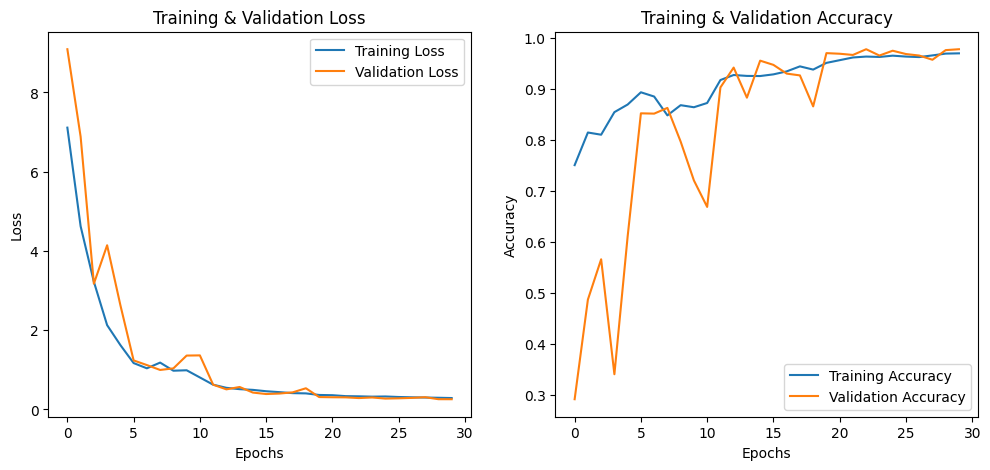

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

plot_learning_curves(history)

In [ ]:
y_true, y_pred = [], []

for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

# Precision Recall F1-Score

In [ ]:
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

              precision    recall  f1-score   support

      cloudy       0.97      0.98      0.97       453
      desert       0.97      0.97      0.97       339
  green_area       0.99      0.98      0.98       450
       water       0.98      0.98      0.98       450

    accuracy                           0.98      1692
   macro avg       0.98      0.98      0.98      1692
weighted avg       0.98      0.98      0.98      1692



# Confusion Matrix

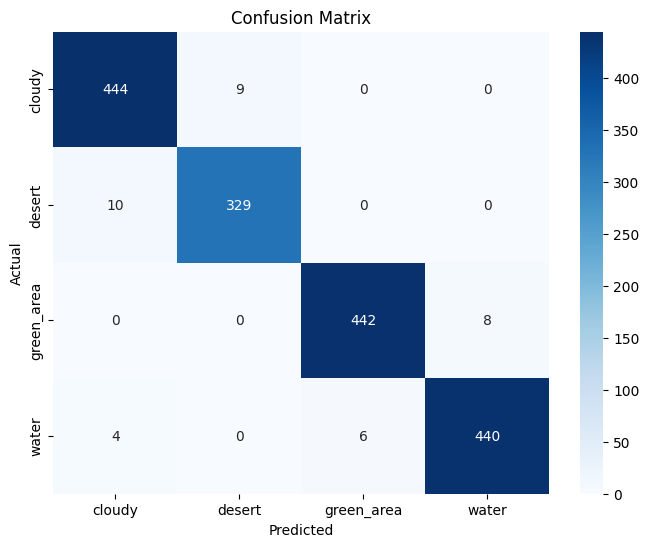

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Z - Test

In [ ]:
from scipy.stats import norm
from scipy.stats import norm, ttest_ind  # Import ttest_ind along with norm
from scipy.stats import f_oneway # Import the norm object from scipy.stats

from scipy.stats import norm

def z_test(p1, p2, n1, n2):
    if n1 == 0 or n2 == 0:
        return None, None  # Avoid division by zero
    p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
    standard_error = np.sqrt(max(p_combined * (1 - p_combined) * (1/n1 + 1/n2), 1e-10))  # Avoid zero error
    z_score = (p1 - p2) / standard_error
    p_value = max(2 * (1 - norm.cdf(abs(z_score))), 1e-10)  # Ensure p-value isn't 0
    return z_score, p_value

train_samples = train_generator.samples
test_samples = validation_generator.samples
train_accuracy = history.history['accuracy'][-1]
test_accuracy = history.history['val_accuracy'][-1]
z_score, p_value = z_test(train_accuracy, test_accuracy, train_samples, test_samples)
print(f"Z-score: {z_score:.4f}, P-value: {p_value:.4f}")

t_stat, t_p_value = ttest_ind(np.array(history.history['accuracy']),
                              np.array(history.history['val_accuracy']), equal_var=False)
print(f"T-test Statistic: {t_stat:.4f}, P-value: {t_p_value:.4f}")

train_acc_noisy = np.array(history.history['accuracy']) + np.random.normal(0, 0.0001, len(history.history['accuracy']))
val_acc_noisy = np.array(history.history['val_accuracy']) + np.random.normal(0, 0.0001, len(history.history['val_accuracy']))
anova_stat, anova_p_value = f_oneway(train_acc_noisy, val_acc_noisy)
print(f"ANOVA F-statistic: {anova_stat:.4f}, P-value: {anova_p_value:.4f}")


Z-score: -1.7212, P-value: 0.0852
T-test Statistic: 2.0701, P-value: 0.0461
ANOVA F-statistic: 4.2892, P-value: 0.0428
